# Netflix gneugneu

# Introduction

**Comment expliquer le succès de Netflix ?** Les années 2010 ont vu l’essor des plateformes de streaming guidées par l’exemple du mastodonte Netflix. Dominant largement le marché pendant des années, on constate aujourd’hui une multiplication de plateformes (Amazon Prime, Disney +,  Hulu…) qui cherchent à concurrencer Netflix dans son statut de numéro un. Dès lors, comment Netflix a-t-elle réussi à conserver sa place ? Comment a-t-elle développé le contenu proposé pour fidéliser ses consommateurs ? Existe-t-il un profil type des séries produites par Netflix et quels sont les arguments qui rentrent en compte dans la création de ces séries ?

Tout d’abord nous travaillons sur la base de données, nous avons récupéré deux csv formant le corps de notre base que nous nettoyons pour l’adapter à nos besoins et nous les complétons par des classements de séries récupérés par webscrapping.
<br>Nous effectuons ensuite des statistiques descriptives pour observer l’évolution de Netflix dans son contenu que l’on compare aux autres plateformes.
<br>Et enfin nous étudions les caractéristiques des séries présentes sur Netflix pour essayer d’identifier les paramètres qui auraient un impact sur leur succès puis nous nous intéressons aux éventuels profils type des séries Netflix.

## Importation des Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import bs4
import re
import copy
import collections as co

import plotly as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots
import matplotlib.pyplot as mplt

from sklearn.preprocessing import StandardScaler
import seaborn as sns

import requests

# Récupération et traitement des données

On a les bases : 
- `All streaming shows` (AS) trouvée sur kaggle
- `Netflix titles` trouvée sur kaggle
- `IMDB 250` scrapée sur le site éponyme : df_tvshow
- `df_carac` scrappée sur "https://www.the-numbers.com/home-market/netflix-daily-chart/2020/12/06"

On avait commencé à travailler sur `Netflix Titles` mais le manque de variables exploitables pour une modélisation nous a mené à chercher d'autres bases.<br>

On avait donc scrappé IMDB pour récupérer le TOP 250 des films et des séries (selon IMDB), cette base n'a finalement pas beaucoup servi les titres étant en français (impossible de trouver une version du site où les titres étaient en anglais).<br>

On a ensuite scrapper les données du site 'https://www.the-numbers.com/home-market/netflix-daily-chart/2020/12/06' qui recense quotidiennement depuis mi mars 2020 le Top 10 Netflix, donne quelques caractéristiques de ces films et séries et calcule un score d'audience : chaque jour à la première place donne 10 points, à la deuxième 9 etc...<br>

Nous nous sommes alors heurté à un problème de cohérence temporelle. En effet notre base originale avec les caractéristiques des séries (`Netflix Titles`) s'arrêtait en janvier 2020 et notre base des Top quotidien commencaient début 2020, la plupart des titres contenus dans cette dernière n'apparaissent donc pas dans la première.<br>

Nous avons donc cherché une autre base, plus récente. Pour cela nous avons du prendre une base plus large en termes de platforme mais avec seulement des séries. `All streaming shows` recense toutes les séries diffusées sur des plateformes.<br>

## `Net-tit`

In [3]:
#cellule Myrtille
#Net_tit = pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\netflix_titles.csv')

In [4]:
#cellule léo
Net_tit = pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\netflix_titles.csv')

In [5]:
#Net_tit.head(5)

On compte le nombre de valeurs manquantes pour `date_added` et `release_year`, les deux variables sur lesquelles on peut faire des opérations numériques (pour comparer les séries/films qui ont été créés par Netflix ou juste rachetés)


In [6]:
Net_tit[['date_added']].isna().sum() #11 valeurs manquantes
Net_tit[['release_year']].isna().sum() #0 valeurs manquantes

release_year    0
dtype: int64

On créé une variable `year_added` codée en int qui renseigne l'année où le film/série a été ajouté sur Netflix et on remplace les valeurs manquantes par des zéros. Pour cela on crée une regex qui nous permet d'extraire l'année de la date complète donnée dans date_added. On remplace ensuite les NaN par des 0 et on convertit les valeurs en entiers.

In [7]:
Net_tit[['date_added']].iloc[0:6233]

,date_added
0,"September 9, 2019"
1,"September 9, 2016"
2,"September 8, 2018"
3,"September 8, 2018"
4,"September 8, 2017"
...,...
6228,NaN
6229,NaN
6230,NaN
6231,NaN


In [8]:
regex = r'([0-2][0-9][0-9][0-9])'
Net_tit['year_added'] = Net_tit['date_added'].str.extract(regex,expand=True)
Net_tit['year_added'] = Net_tit['year_added'].fillna(0)
Net_tit['year_added'] = Net_tit['year_added'].astype(str).astype(int)

### Création de `df1`

On choisit des colonnes de Net_tit puis on ordonne par ordre décroissant de sortie. Pour cela on utilise release_year. 

In [9]:
df1 = Net_tit[['type', 'title','director', 'cast', 'date_added', 'year_added', 'release_year', 'duration', 'listed_in']]
df1 = df1.sort_values('release_year', ascending = False)
df1.head(5)

,type,title,director,cast,date_added,year_added,release_year,duration,listed_in
3467,TV Show,Medical Police,NaN,"Erinn Hayes, Rob Huebel, Malin Akerman, Rob Co...","January 10, 2020",2020,2020,1 Season,"Crime TV Shows, TV Action & Adventure, TV Come..."
3249,Movie,All the Freckles in the World,Yibrán Asuad,"Hánssel Casillas, Loreto Peralta, Andrea Sutto...","January 3, 2020",2020,2020,90 min,"Comedies, International Movies, Romantic Movies"
3220,TV Show,Dracula,NaN,"Claes Bang, Dolly Wells, John Heffernan","January 4, 2020",2020,2020,1 Season,"British TV Shows, International TV Shows, TV D..."
3427,Movie,Leslie Jones: Time Machine,"David Benioff, D.B. Weiss",Leslie Jones,"January 14, 2020",2020,2020,66 min,Stand-Up Comedy
3436,TV Show,The Healing Powers of Dude,NaN,"Jace Chapman, Larisa Oleynik, Tom Everett Scot...","January 13, 2020",2020,2020,1 Season,"Kids' TV, TV Comedies, TV Dramas"


### Création de `df_movie` et `df_tvshow`

On sépare `df1` en deux data frames, l'un pour les séries, l'autre pour les films.

In [10]:
df1[['type']].isna().sum() #pas de valeurs manquantes

type    0
dtype: int64

In [11]:
df_tvshow = df1[df1['type'].isin(["TV Show"])]
df_movie = df1[df1['type'].isin(['Movie'])]

On trace un graphique pour comparer le nombre de séries et de films ajoutés sur Netflix.

In [13]:
"""----------Fonction traçant le nombre de films et de séries ajoutées au fil des années----------"""

vc1 = df_tvshow["year_added"].value_counts().reset_index()
vc1 = vc1.rename(columns = {"year_added" : "count", "index" : "year_added"})
vc1['percent'] = vc1['count'].apply(lambda x : 100*x/sum(vc1['count']))
vc1 = vc1.sort_values("year_added")

vc2 = df_movie["year_added"].value_counts().reset_index()
vc2 = vc2.rename(columns = {"year_added" : "count", "index" : "year_added"})
vc2['percent'] = vc2['count'].apply(lambda x : 100*x/sum(vc2['count']))
vc2 = vc2.sort_values("year_added")

trace1 = go.Scatter(x=vc1["year_added"], y=vc1["count"], name="TV Shows", marker=dict(color="#a678de"))
trace2 = go.Scatter(x=vc2["year_added"], y=vc2["count"], name="Movies", marker=dict(color="#6ad49b"))
data = [trace1, trace2]
layout = go.Layout(title="Evolution du contenu au fil des années", legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.update_xaxes(range=[2010, 2020])
fig.show()

On constate qu'il y a facilement deux fois plus de films que de séries ajoutées chaque année.
Par conséquent on pourrait penser que Netflix propose beaucoup plus de films cependant nous faisons ici face à l'une des limites de notre base. En effet une série de 5 saisons avec 20 épisodes par saison a le même poids qu'un film.

Néanmoins, on peut tout de même déduire de ce graphique que le catalogue de films présents sur Netflix ne doit pas être négligé. Ce serait une erreur de réduire cette plateforme aux seules séries.

Par la suite nous nous focalisons sur les séries car elles représentent l'activité principale de Netflix et parce que nous sommes confrontés aux lacunes de notre base.

NB : La chute pour 2020 est dû à la base qui ne contient pas les séries et les films diffusés après janvier 2020.

## Top 250 IMDB

### `recup_notes`

On crée une fonction qui met dans un data frame les notes des 250 mieux notés sur ImDB (films ou séries).

In [14]:
def recup_notes(url):

    """On récupère la page internet------------------"""
    from urllib import request
    request_text = request.urlopen(url).read()
    #print(request_text[:1000]) 
    page = bs4.BeautifulSoup(request_text, "lxml")
    #print(type(page))


    """On récupère les données------------------"""
    tableau=page.find("table",{'class' : 'chart full-width'})
    #print(tableau)
    table_body=tableau.find('tbody')
    rows = table_body.find_all('tr')
    #print (rows)


    """On récupére les élements correspondant au titre et à la note--------------"""
    new_rows=[] #on crée une liste vide dans laquelle on va mettre le contenu des lignes
    for row in rows:
        cols = row.find_all('td')
        #print(type(cols))
        new_cols = []
        for ele in cols:
            new_cols.append([ele.text.strip()])
        #print(new_cols)
        new_cols=new_cols[1:3]
        #new_cols_title=new_cols[0]
        new_cols[0]= new_cols[0][0]
        new_cols[1]= float(new_cols[1][0])
        new_rows.append(new_cols)
  #print (new_rows)

    """On nettoie les élements pour n'avoir que des listes de titres et notes"""
    """L'élement correspondant au titre est entouré d'informations parasites, on s'en
    débarasse avec 2 regex successives"""

    regex_debut = "[\d]?[\d]?[\d]\.[\n][\s]{6}"
    regex_fin="[\n]\([1-2][\d]{3}\)"

    clean_rows=copy.copy(new_rows)

    for i in range(len(new_rows)):
        a_suppr=re.findall(regex_debut,new_rows[i][0])
        #print (a_suppr[0])
        clean_rows[i][0]=new_rows[i][0].replace(a_suppr[0],"")
    #print (clean_rows)

    really_clean_rows=copy.copy(clean_rows)

    for i in range(len(clean_rows)):
        a_suppr_fin=re.findall(regex_fin,clean_rows[i][0])
        #print (a_suppr_fin[0])
        really_clean_rows[i][0]=clean_rows[i][0].replace(a_suppr_fin[0],"")
    #print (really_clean_rows)

    """On crée un dictionnaire dans lequel on met le contenu des lignes nettoyées
    La clé est le titre, la valeur la note."""
    dico_top = dict()
    for row in really_clean_rows:
        cols=row
        dico_top[cols[0]] = cols[1:]
    dico_top

    """On crée le dataframe"""
    df_top = pd.DataFrame.from_dict(dico_top,orient='index')
  

    """"On rajoute une index différente du titre"""
    df_top.reset_index(level=0, inplace=True)

    """On change le nom des colonnes"""
    df_top.rename(columns={'index': 'Title', 0: 'IMDb rating'}, inplace=True)

    #print(df_top)
    return (df_top)


### Création de `df_top_shows` et `df_top_movies`

In [15]:
url_top_shows = "https://www.imdb.com/chart/toptv/?ref_=nv_tvv_250"
url_top_movies= "https://www.imdb.com/chart/top/?ref_=nv_mv_250"

In [16]:
df_top_shows=recup_notes(url_top_shows)
df_top_shows.head()

,Title,IMDb rating
0,Planet Earth II,9.5
1,Planète Terre,9.4
2,Frères d'armes,9.4
3,Breaking Bad,9.4
4,Chernobyl,9.4


In [17]:
df_top_movies=recup_notes(url_top_movies)
df_top_movies.head()

,Title,IMDb rating
0,Les évadés,9.2
1,Le parrain,9.1
2,"Le parrain, 2ème partie",9.0
3,The Dark Knight: Le chevalier noir,9.0
4,12 hommes en colère,8.9


On sauvegarde ces deux df dans deux fichiers csv

In [15]:
a=df_top_movies.to_csv("df_top_movies.csv", index = False)
a=df_top_shows.to_csv("df_top_shows.csv", index = False)

## Top Netflix quotidien

De mi mars à début décembre on a 252 top quotidiens d'environ 10 lignes. On a choisi de les concaténer par mois. Comme cette opération prend un certain temps nous avons enregistrer les df obtenus sous forme de csv pour éviter de devoir répéter l'opération et les opérations de concaténations sont sous forme de commentaire (pour éviter qu'elle se lancent lors d'un Run All).

### `recup_top_netflix_gen`

Pour scrapper ces 252 top quotidiens on a défini une fonction qui prend comme argument la date souhaitée *(aaaa/mm/jj)* et en argument conditionnel le début de l'url.<br>La fonction renvoie le df correspondant.

In [24]:
def recup_top_netflix_gen(date,url="https://www.the-numbers.com/home-market/netflix-daily-chart/"):

    url_enrichi = url+date
    from urllib.request import Request, urlopen
    req_text = urlopen(Request(url_enrichi, headers={'User-Agent': 'Mozilla/5.0'})).read()
    page = bs4.BeautifulSoup(req_text, "lxml")
    #print (page)

    """On récupère les données------------------"""
    #tableau=page.find("table",{'class' : 'chart full-width'})
    tableau=page.find("div",{'id':'page_filling_chart'})
    #print(tableau)
    #table_body=tableau.find('tbody')
    #print(table_body)
    rows = tableau.find_all('tr')
    #print (rows)

  
    """On récupére tous les élements correspondant au titre et à la note et On crée un dictionnaire dans lequel on met le contenu des lignes nettoyées
    L'index est le titre, la valeur la note.
    --------------"""
    new_rows=[]#on crée une liste vide dans laquelle on va mettre le contenu des lignes
    new_cols = 10*[[]]
    dico_top_netflix = dict()
    i = 0
    for row in rows:
        cols = row.find_all('td') # c'est une liste
        cols = [ele.text.strip() for ele in cols]
        #print (cols)
        if len(cols)> 0:
            dico_top_netflix[cols[0]] = cols[1:]
    #print(dico_top_netflix)    

    """"""

    """On crée ENFIN le dataframe"""
    df_top_netflix_gen = pd.DataFrame.from_dict(dico_top_netflix,orient='index')

    """On rajoute une index différente du titre"""
    for row in rows:
        cols = row.find_all('th')
        #print(cols)
        if len(cols) > 0 : 
            cols = [ele.get_text(separator=' ').strip().title() for ele in cols]
            columns_title = cols
    #print (columns_title)
    

    """On change le nom des colonnes"""
    df_top_netflix_gen.columns=columns_title[1:]
    
    """On vire les colonnes qui ne nous intéresse pas"""
    del(df_top_netflix_gen['Yd'])
    del(df_top_netflix_gen['Lw'])
    del(df_top_netflix_gen['Watch Now'])
    
    
    """On rajoute une colonne 'Measure Date' """
    df_top_netflix_gen['Measure Date']= [date]*df_top_netflix_gen.shape[0]
    #print ("Graph au "+ date)
    return (df_top_netflix_gen)

In [23]:
#S'il y a un problème d'url qui empêche le web scrapping

#import ssl

#ssl._create_default_https_context = ssl._create_unverified_context
#response = urllib.request.urlopen('https://www.python.org')
#print(response.read().decode('utf-8'))

<!doctype html>
<!--[if lt IE 7]>   <html class="no-js ie6 lt-ie7 lt-ie8 lt-ie9">   <![endif]-->
<!--[if IE 7]>      <html class="no-js ie7 lt-ie8 lt-ie9">          <![endif]-->
<!--[if IE 8]>      <html class="no-js ie8 lt-ie9">                 <![endif]-->
<!--[if gt IE 8]><!--><html class="no-js" lang="en" dir="ltr">  <!--<![endif]-->

<head>
    <meta charset="utf-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">

    <link rel="prefetch" href="//ajax.googleapis.com/ajax/libs/jquery/1.8.2/jquery.min.js">
    <link rel="prefetch" href="//ajax.googleapis.com/ajax/libs/jqueryui/1.12.1/jquery-ui.min.js">

    <meta name="application-name" content="Python.org">
    <meta name="msapplication-tooltip" content="The official home of the Python Programming Language">
    <meta name="apple-mobile-web-app-title" content="Python.org">
    <meta name="apple-mobile-web-app-capable" content="yes">
    <meta name="apple-mobile-web-app-status-bar-style" content="black">

    <meta name="

Le Top10 Netflix aux US le 13 décembre 2020.

In [25]:
df_12_13=recup_top_netflix_gen("2020/12/13")
df_12_13

,Title,Type,Netflix Excl.,Netflix Release Date,Days In Top 10,Viewer- Ship Score,Measure Date
1,Ava,Movie,,,6,50,2020/12/13
2,The Prom,Movie,Yes,"Dec 11, 2020",2,15,2020/12/13
3,Manhunt,TV Show,,,4,29,2020/12/13
4,How the Grinch Stole Christmas,Movie,,,14,36,2020/12/13
5,Triple 9,Movie,,,5,28,2020/12/13
6,Selena: The Series,TV Show,Yes,"Dec 4, 2020",9,81,2020/12/13
7,Big Mouth,TV Show,Yes,"Sep 29, 2017",9,74,2020/12/13
8,Virgin River,TV Show,Yes,"Nov 27, 2020",16,128,2020/12/13
9,The Christmas Chronicles 2,Movie,Yes,"Nov 25, 2020",13,90,2020/12/13
10,The Queen's Gambit,TV Show,Yes,"Oct 23, 2020",51,392,2020/12/13


### Création des df des mois et concaténation vers `df_carac`

On crée d'abord une liste de toutes les dates avec un Top 10.

Pour cela on crée une liste avec toutes les dates de 2020 puis on enlève celles pour lesquelles on a pas de Top. On compte bien 252 dates valides.

In [26]:
liste_dates_valides=[]
for m in range (3,13):
    m=str(m)
    if len(m)==1:
        m = "0"+m
    for d in range (1,32):
        d=str(d)
        if len(d)==1:
            d="0"+d
        date = "2020/"+m+"/"+d
        liste_dates_valides.append(date)

#On supprime les dates sans valeurs
for i in ['2020/03/01', '2020/03/02', '2020/03/03', '2020/03/04', '2020/03/05', '2020/03/06', '2020/03/07', '2020/03/08', 
          '2020/03/09', '2020/03/10', '2020/03/11', '2020/03/12', '2020/03/13', '2020/03/14', '2020/03/15', '2020/03/16', 
          '2020/03/17', '2020/03/18', '2020/03/19', '2020/03/20', '2020/03/21', '2020/03/22', '2020/03/23', '2020/03/28', 
          '2020/03/29', '2020/04/04', '2020/04/05', '2020/04/11', '2020/04/12', '2020/04/18', '2020/04/19', '2020/04/25', 
          '2020/04/26', '2020/08/09', '2020/08/30', '2020/12/14', '2020/12/15', '2020/12/16', '2020/12/17', '2020/12/18',
          '2020/12/19', '2020/12/20', '2020/12/21', '2020/12/22', '2020/12/23', '2020/12/24', '2020/12/25', '2020/12/26', 
          '2020/12/27', '2020/12/28', '2020/12/29', '2020/12/30', '2020/12/31', '2020/04/31', '2020/06/31', '2020/09/31', 
          '2020/11/31', '2020/08/06']:
    liste_dates_valides.remove(i)
print ('On a ',len (liste_dates_valides), ' dates valides.')

On a  252  dates valides.


On crée un string avec toutes les dates séparées par une virgule.

In [27]:
dates=""
for i in liste_dates_valides:
    dates=dates+i+','
dates=dates[:-1]

On crée une liste avec pour éléments les listes des dates valides de chaque mois. On en fait un dictionnaire : `dico_mois`.

In [28]:
janvier = []
fevrier = []
mars=[]
avril=[]
mai=[]
juin=[]
juillet=[]
aout=[]
septembre=[]
octobre=[]
novembre=[]
decembre=[]
mois = [[],janvier,fevrier,mars,avril,mai,juin,juillet,aout,septembre,octobre,novembre,decembre]
for i,moi in enumerate(mois):
    
    if i <10: regex = re.compile("([2][0][2][0]/[0]["+str(i)+"]/[0-3][0-9])")
    else : regex = re.compile("([2][0][2][0]/[1]["+str(i-10)+"]/[0-3][0-9])")
    mois[i].append(regex.findall(dates))
mois=mois[3:]

dico_mois={'mars': mars, 'avril': avril, 'mai': mai, 'juin': juin, 'juillet': juillet,'aout': aout,
           'septembre': septembre, 'octobre':octobre, 'novembre': novembre, 'decembre': decembre}

### Concaténation

On crée `dico_df_mois` qui contiendra le df de chaque mois, on l'initie en mettant le premier df de chaque mois.

In [29]:
df_mars = recup_top_netflix_gen("2020/03/24")
df_avril = recup_top_netflix_gen("2020/04/01")
df_mai = recup_top_netflix_gen("2020/05/01")
df_juin = recup_top_netflix_gen("2020/06/01")
df_juillet = recup_top_netflix_gen("2020/07/01")
df_aout = recup_top_netflix_gen("2020/08/01")
df_septembre = recup_top_netflix_gen("2020/09/01")
df_octobre = recup_top_netflix_gen("2020/10/01")
df_novembre = recup_top_netflix_gen("2020/11/01")
df_decembre = recup_top_netflix_gen("2020/11/01")

dico_df_mois={"mars" : df_mars, "avril" : df_avril, "mai":df_mai , "juin":df_juin , "juillet":df_juillet,
              "aout":df_aout ,"septembre" :df_septembre ,"octobre": df_octobre, "novembre" :df_novembre,"decembre": df_decembre}

On enrichit chaque df avec les autres jours du mois.

Cette cellule est longue à éxécuter : on la neutralise et on store les df obtenus dans des csv que nous utiliserons ensuite.

In [30]:
#for key,value in dico_mois.items():
#    print (key)
#    dico_df_mois[key] = recup_top_netflix_gen(value[0][0])
#    a_conc=0
#    for i in value[0][1:]:
#        a_conc = recup_top_netflix_gen(i)
#        dico_df_mois[key] = pd.concat([dico_df_mois[key],a_conc])
#        #print(dico_df_mois[key])


In [31]:
#for moi, df_moi in dico_df_mois.items():
#    a=df_moi.to_csv("df_"+moi+".csv", index = False) 

On récupère les CSV correspondants.

In [32]:
#Cellule Myrtille
df_mars=pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\df_mars.csv')
df_avril=pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\df_avril.csv')
df_mai=pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\df_mai.csv')
df_juin=pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\df_juin.csv')
df_juillet=pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\df_juillet.csv')
df_aout=pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\df_aout.csv')
df_septembre=pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\df_septembre.csv')
df_octobre=pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\df_octobre.csv')
df_novembre=pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\df_novembre.csv')
df_decembre=pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\df_decembre.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Utilisateur\\Documents\\GitHub\\Projet_Python_2A\\df_mars.csv'

In [33]:
#Cellule Léo
df_mars=pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\df_mars.csv')
df_avril=pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\df_avril.csv')
df_mai=pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\df_mai.csv')
df_juin=pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\df_juin.csv')
df_juillet=pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\df_juillet.csv')
df_aout=pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\df_aout.csv')
df_septembre=pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\df_septembre.csv')
df_octobre=pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\df_octobre.csv')
df_novembre=pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\df_novembre.csv')
df_decembre=pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\df_decembre.csv')

On remarque que la construction du `Score` fait qu'il est strictement croissant pour une fonction donnée.
On va donc ordonner le df d'abord par titre puis par date décroissante. Ainsi la première occurence d'un titre donne son score le plus récent (et donc maximal), pour un mois donné.


On crée une fonction `sortby` qui ordonne les df de cette manière.

In [34]:
def sortby(df):
    return df.sort_values(['Title','Measure Date'],ascending=(True,False))
#sortby(df_mars)

In [35]:
sortby(df_decembre).head(10)

,Title,Type,Netflix Excl.,Netflix Release Date,Days In Top 10,Viewer- Ship Score,Measure Date
68,Alien Worlds,TV Show,Yes,"Dec 2, 2020",5,17,2020/12/07
58,Alien Worlds,TV Show,Yes,"Dec 2, 2020",4,15,2020/12/06
47,Alien Worlds,TV Show,Yes,"Dec 2, 2020",3,13,2020/12/05
33,Alien Worlds,TV Show,Yes,"Dec 2, 2020",2,10,2020/12/04
27,Alien Worlds,TV Show,Yes,"Dec 2, 2020",1,3,2020/12/03
120,Ava,Movie,NaN,NaN,6,50,2020/12/13
110,Ava,Movie,NaN,NaN,5,40,2020/12/12
100,Ava,Movie,NaN,NaN,4,30,2020/12/11
92,Ava,Movie,NaN,NaN,3,20,2020/12/10
82,Ava,Movie,NaN,NaN,2,12,2020/12/09


On crée `dico_carac` où chaque entrée est un titre différent et les valeurs sont le type, l'exclusivité Netflix et le Score.
On utilise les df dans le sens anti-chronologique pour récupérer le score le plus récent.

In [36]:
liste_df = [df_decembre,df_novembre,df_octobre,df_septembre,df_aout,df_juillet,df_juin,df_mai,df_avril,df_mars]
dico_carac=dict()

for df_moi in liste_df:
    for i in range(sortby(df_moi).shape[0]):
        if sortby(df_moi)['Title'][i] not in dico_carac:
            dico_carac[sortby(df_moi)['Title'][i]]=[sortby(df_moi)['Type'][i],sortby(df_moi)['Netflix Excl.'][i],sortby(df_moi)['Viewer- Ship Score'][i]]

#dico_carac

### Création de `df_carac`
On crée le df correspondant

In [37]:
df_carac = pd.DataFrame.from_dict(dico_carac,orient='index')
df_carac.columns=['Type','Netflix Exclusive','Score']
df_carac= df_carac.sort_values('Score',ascending=False)
df_carac

,Type,Netflix Exclusive,Score
The Queen's Gambit,TV Show,Yes,340
Outer Banks,TV Show,Yes,259
The Umbrella Academy,TV Show,Yes,231
365 Dni,Movie,NaN,198
Avatar the Last Airbender,TV Show,NaN,196
...,...,...,...
How to Train Your Dragon 2,Movie,NaN,1
Legacies,TV Show,NaN,1
Community,TV Show,NaN,1
The Christmas Chronicles,Movie,Yes,1


On remplit les valeurs manquantes de Netflix Exclusive par `'No'`. 

En effet, sur le site original la variable ne prend comme modalité que 'Yes' ou rien, on considère que rien veut dire que la série n'est pas une série originale Netflix. 

In [38]:
df_carac['Netflix Exclusive']=df_carac['Netflix Exclusive'].fillna('No')

On reset l'index et renomme la colonne `'Title'`.

In [39]:
df_carac=df_carac.reset_index()
df_carac.columns=['Title','Type','Netflix Exclusive','Score']

In [40]:
df_carac.head()

,Title,Type,Netflix Exclusive,Score
0,The Queen's Gambit,TV Show,Yes,340
1,Outer Banks,TV Show,Yes,259
2,The Umbrella Academy,TV Show,Yes,231
3,365 Dni,Movie,No,198
4,Avatar the Last Airbender,TV Show,No,196


On store ce df sous un csv du même nom.

In [41]:
gfg_csv_data = df_carac.to_csv('df_carac.csv', index = False)

## All Streaming Shows (`AS`)

All Streaming Shows est une base trouvée sur Kaggle qui recense les Séries (uniquement) diffusées en 2020.

Elle présente l'avantage de contenir plusieurs valeurs exploitables en particulier : le genre, la plateforme de diffusion et les notes IMDB et Rotten Tomatoes.

In [44]:
#Cellule léo
AS= pd.read_csv(r'C:\Users\User\Documents\GitHub\Projet_Python_2A\All_Streaming_Shows.csv',sep=',')
#AS.shape[0] #12 353
#AS.head(5)

In [43]:
#Cellule Myrtille
AS= pd.read_csv(r'C:\Users\Utilisateur\Documents\GitHub\Projet_Python_2A\All_Streaming_Shows.csv',sep=',')
AS.shape[0] #12 353
AS.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Utilisateur\\Documents\\GitHub\\Projet_Python_2A\\All_Streaming_Shows.csv'

### Nettoyage préliminaire et ajout de `Top IMDB`

On nettoie la colonne `No of Seasons` pour ne conserver que le nombre.

Pour cela on utilise une regex.

In [45]:
regex = r'([0-9]?[0-9])'
AS['No of Seasons'] = AS['No of Seasons'].str.extract(regex,expand=True)
AS['No of Seasons'] = AS['No of Seasons'].fillna(0)
AS['No of Seasons'] = AS['No of Seasons'].astype(str).astype(int)

In [46]:
AS.head()

,Series Title,Year Released,Content Rating,IMDB Rating,R Rating,Genre,Description,No of Seasons,Streaming Platform
0,Breaking Bad,2008,18+,9.5,100,"Crime,Drama","When Walter White, a New Mexico chemistry teac...",5,Netflix
1,Game of Thrones,2011,18+,9.3,99,"Action & Adventure,Drama",Seven noble families fight for control of the ...,8,"HBO MAX,HBO"
2,Rick and Morty,2013,18+,9.2,97,"Animation,Comedy",Rick is a mentally-unbalanced but scientifical...,4,"Free Services,HBO MAX,Hulu"
3,Stranger Things,2016,16+,8.8,96,"Drama,Fantasy","When a young boy vanishes, a small town uncove...",3,Netflix
4,The Boys,2019,18+,8.7,95,"Action & Adventure,Comedy",A group of vigilantes known informally as “The...,2,Prime Video


On enrichi ensuite cette base d'une variable binaire 'Top IMDB' qui prend 1 comme valeur quand la série figure dans le Top IMDB, 0 sinon.

Nous avons codé cette variable en observant dans notre base Top IMDB 250 qu'une note supérieure à 8,4 valait une inscription dans le Top.

(Il n'était pas possible de directement fusioner les deux bases à cause de l'incompatibilité des titres :en francais pour Top IMDB et anglais ici.)

In [47]:
df_top_shows.tail()

,Title,IMDb rating
239,Community,8.4
240,Vikings,8.4
241,"Unsere Mütter, unsere Väter",8.4
242,Clannad: After Story,8.4
243,Wentworth,8.4


In [48]:
AS['Top IMDB'] = AS['IMDB Rating'].apply(lambda x: '1' if x >= 8.4 else '0')
AS['Top IMDB'] = AS['Top IMDB'].astype(str).astype(int)

In [49]:
AS.sort_values('IMDB Rating',ascending=False)[745:760]

,Series Title,Year Released,Content Rating,IMDB Rating,R Rating,Genre,Description,No of Seasons,Streaming Platform,Top IMDB
203,After Life,2019,18+,8.4,83,"Comedy,Drama",Tony had a perfect life. But after his wife Li...,2,Netflix,1
208,Banshee,2013,18+,8.4,83,"Drama,Thriller",Banshee is an American drama television series...,4,Cinemax,1
12,Supernatural,2005,16+,8.4,93,"Drama,Fantasy","When they were boys, Sam and Dean Winchester l...",15,"Free Services,Netflix,TNT",1
580,M*A*S*H,1972,7+,8.4,76,"Comedy,Drama",The 4077th Mobile Army Surgical Hospital is st...,11,"Hulu,TVLand",1
197,The Morning Show,2019,18+,8.4,83,"Comedy,Drama",A behind-the-scenes look at the lives of the p...,1,Apple TV+,1
209,Narcos: Mexico,2018,18+,8.4,83,"Action & Adventure,Crime",See the rise of the Guadalajara Cartel as an A...,2,Netflix,1
195,Ash vs Evil Dead,2015,18+,8.4,83,"Comedy,Horror",Bruce Campbell reprises his role as Ash Willia...,3,"Netflix,Starz",1
177,Taboo,2017,16+,8.4,84,"Drama,Mystery",Adventurer James Keziah Delaney returns to Lon...,1,Hulu,1
370,My So-Called Life,1994,16+,8.3,79,"Drama,Comedy","The life of a 15 year-old high school student,...",1,Free Services,0
76,Prison Break,2005,16+,8.3,88,"Drama,Action & Adventure","Due to a political conspiracy, an innocent man...",5,Hulu,0


### Création de sous bases propres aux plateformes `AS_N`, `AS_P`, `AS_H`, `AS_D`, `AS_F`

On aura donc une base par plateforme pour : Netflix, Prime Video, Hulu, Disney+ et fuboTV.

L'inconvénient de cette façon et de le faire est qu'on exclue les titres où plusieurs plateformes sont renseignées.

On peut considérer que ce sont des bases avec seulement les "exclusivités" de chaque plateforme.

In [50]:
AS['Streaming Platform'].isin(['Netflix']).sum() #1 427 titres Netflix
AS_N=AS[AS['Streaming Platform'].isin(['Netflix'])]
AS_P=AS[AS['Streaming Platform'].isin(['Prime Video'])]
AS_H=AS[AS['Streaming Platform'].isin(['Hulu'])]
AS_D=AS[AS['Streaming Platform'].isin(['Disney+'])]
AS_F=AS[AS['Streaming Platform'].isin(['fuboTV'])]

gfg_csv_data = AS_N.to_csv('AS_N.csv', index = False)

In [51]:
print ('On a ',AS['Streaming Platform'].isin(['Netflix']).sum()," titres pour Netflix, ",
       AS['Streaming Platform'].isin(['Prime Video']).sum()," pour Prime Video, ",
      AS['Streaming Platform'].isin(['Hulu']).sum(), " pour Hulu et ",
      AS['Streaming Platform'].isin(['fuboTV']).sum()," pour fuboTV.")

On a  1427  titres pour Netflix,  1184  pour Prime Video,  665  pour Hulu et  298  pour fuboTV.


## Jointures

On effectue les jointures suivantes :

- **df_tvshow x cara** = `OGTV_x_carac`

- **df_movie x carac** = `OGM_x_carac`

- **AS x carac**

- **AS_N x carac**

In [53]:
OGTV_x_carac=df_tvshow.set_index('title').join(df_carac.set_index('Title'))
OGTV_x_carac.rename(columns={'index': 'Title'}, inplace=True)
gfg_csv_data = OGTV_x_carac.to_csv('OGTV_x_carac.csv', index = False)

OGM_x_carac=df_movie.set_index('title').join(df_carac.set_index('Title'))
OGM_x_carac.rename(columns={'index': 'Title'}, inplace=True)
gfg_csv_data = OGM_x_carac.to_csv('OGM_x_carac.csv', index = False) 

In [54]:
OGTV_x_carac.sort_values('Score',ascending=False).head()

,type,director,cast,date_added,year_added,release_year,duration,listed_in,Type,Netflix Exclusive,Score
The Umbrella Academy,TV Show,NaN,NaN,"February 15, 2019",2019,2019,1 Season,"TV Action & Adventure, TV Mysteries, TV Sci-Fi...",TV Show,Yes,231.0
Dead to Me,TV Show,NaN,"Christina Applegate, Linda Cardellini, James M...","May 3, 2019",2019,2019,1 Season,"TV Comedies, TV Dramas",TV Show,Yes,175.0
Ozark,TV Show,NaN,"Jason Bateman, Sofia Hublitz, Laura Linney, Sk...","August 31, 2018",2018,2018,2 Seasons,"Crime TV Shows, TV Dramas, TV Thrillers",TV Show,Yes,169.0
The Crown,TV Show,NaN,"Claire Foy, John Lithgow, Matt Smith, Vanessa ...","November 17, 2019",2019,2019,3 Seasons,"British TV Shows, International TV Shows, TV D...",TV Show,Yes,138.0
Riverdale,TV Show,Rob Seidenglanz,"K.J. Apa, Lili Reinhart, Camila Mendes, Cole S...","May 23, 2019",2019,2019,3 Seasons,"Crime TV Shows, TV Dramas, TV Mysteries",TV Show,No,103.0


In [55]:
print ("On a seulement ",OGTV_x_carac['Score'].notna().sum()," scores, c'est très peu, d'où l'utilisation de AS et ses dérivées.")

On a seulement  45  scores, c'est très peu, d'où l'utilisation de AS et ses dérivées.


In [56]:
AS_x_carac = AS.set_index('Series Title').join(df_carac.set_index('Title'))
gfg_csv_data = AS_x_carac.to_csv('AS_x_carac.csv', index = False) 

In [57]:
print ("On a ",AS_x_carac['Score'].notna().sum()," scores, ça reste peu, mais c'est un peu mieux.")

On a  118  scores, ça reste peu, mais c'est un peu mieux.


In [58]:
AS_N_x_carac=AS_N.set_index('Series Title').join(df_carac.set_index('Title'))
AS_N_x_carac.rename(columns={'Unnamed: 0': 'Title'}, inplace=True)
gfg_csv_data = AS_N_x_carac.to_csv('AS_N_x_carac.csv', index = False) 

In [59]:
print ("Pour Netflix, on en a ",AS_N_x_carac['Score'].notna().sum())

Pour Netflix, on en a  73


# Analyse descriptive et représentation graphique

## Analyse des genres dans les premières bases Netflix : `df_tvshow` et `df_movie`

### Films v. Séries : `count_genra`
Fonction qui renvoie le nombre d'occurences de chaque genre ce qui permet de tracer les effectifs des genres les plus populaires.

In [60]:
def count_genra (data_f,nombre=22,inv=0,internat=1):
    
    "---------------On récupère les catégories---------------"
    col = "listed_in"
    categories = ", ".join(data_f['listed_in']).split(", ")
    #print (categories)

    if internat != 1:
        while "International TV Shows" in categories:
            categories.remove("International TV Shows")
    while 'International Movies' in categories:
        categories.remove('International Movies')

    #print(categories)
    
    "-----On compte le nombre d'occurences de chaque type et on garde les 'nombre' qui apparaissent le plus souvent-----"
    counter_list = co.Counter(categories).most_common(nombre)
    #print (type(counter_list_all))
    
    "-----On conserve le premier élément de chaque couple de counter_list (ie. sur le genre)-----"
    #On conserve le premier élément de chaque couple de counter_list (ie. sur le genre)
    if inv == 0: labels = [_[0] for _ in counter_list]
    else : labels = [_[0] for _ in counter_list][::-1]
    #print (labels)

    "-----Idem pour le nombre d'occurences-----"
    if inv == 0: values = [_[1] for _ in counter_list]
    else : values = [_[1] for _ in counter_list][::-1]
    
    return(labels,values)    

On peut donc comparer les genres les plus populaires et leurs effectifs pour les films et les séries.

In [65]:
fig = make_subplots(rows=1, cols=2,shared_yaxes=True)

fig.add_trace(go.Bar(
    y=count_genra(df_movie,5)[1], x=count_genra(df_movie,5)[0], 
    orientation = 'v', name='Films', marker_color='orange'),
             row = 1, col =1)

fig.add_trace(go.Bar(
    y=count_genra(df_tvshow,5)[1], x=count_genra(df_tvshow,5)[0],
    orientation = 'v', name='Séries', marker_color='#58FA82'),
             row =1, col=2)

fig.update_layout( template = 'presentation', margin=dict(l=50, r=50, t=60, b=120), title = "Effectifs des Genres")

fig.update_layout(legend=dict( yanchor="top", y=1, xanchor="left", x=0.85))

fig.show()

### Dans le temps

On remarque que les séries sont enregistrées en tant que leur dernière saison sortie. Par exemple, la série The Crown est enregistré comme un seul titre de 3 saisons sorti en 2019. L'analyse dans le temps n'est donc pas pertinente pour les séries, les dates étant tirées vers le présent par construction.

On va donc se concentrer, pour cette partie, sur les films.

On remarque que `year_added` prend ses valeurs entre 2008 et 2020.

In [66]:
df_movie.sort_values("year_added")

,type,title,director,cast,date_added,year_added,release_year,duration,listed_in
6231,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,0,2016,60 min,Movies
3742,Movie,To and From New York,Sorin Dan Mihalcescu,"Barbara King, Shaana Diya, John Krisiukenas, Y...","January 1, 2008",2008,2006,81 min,"Dramas, Independent Movies, Thrillers"
1237,Movie,Splatter,Joe Dante,"Corey Feldman, Tony Todd, Tara Leigh, Erin Way...","November 18, 2009",2009,2009,29 min,Horror Movies
1590,Movie,Just Another Love Story,Ole Bornedal,"Anders W. Berthelsen, Rebecka Hemse, Nikolaj L...","May 5, 2009",2009,2007,104 min,"Dramas, International Movies"
1543,Movie,Mad Ron's Prevues from Hell,Jim Monaco,"Nick Pawlow, Jordu Schell, Jay Kushwara, Micha...","November 1, 2010",2010,1987,84 min,"Cult Movies, Horror Movies"
...,...,...,...,...,...,...,...,...,...
3506,Movie,Dragonheart: A New Beginning,Doug Lefler,"Christopher Masterson, Harry Van Gorkum, Rona ...","January 1, 2020",2020,2000,84 min,"Action & Adventure, Sci-Fi & Fantasy"
3383,Movie,Where the Money Is,Marek Kanievska,"Paul Newman, Linda Fiorentino, Dermot Mulroney...","January 15, 2020",2020,2000,89 min,"Action & Adventure, Comedies, Dramas"
3445,Movie,Betty White: First Lady of Television,Steve Boettcher,"Betty White, Valerie Bertinelli, Georgia Engel...","January 12, 2020",2020,2018,56 min,Documentaries
3564,Movie,Stuart Little,Rob Minkoff,"Michael J. Fox, Jonathan Lipnicki, Geena Davis...","January 1, 2020",2020,1999,85 min,"Children & Family Movies, Comedies"


On crée une fonction qui sort les genres les plus populaires pour 3 années données.

In [67]:
def genra_time(year1,year2,year3,nb=3):
    df1=df_movie[df_movie['year_added'].isin([year1])]
    df2=df_movie[df_movie['year_added'].isin([year2])]
    df3=df_movie[df_movie['year_added'].isin([year3])]
    
    fig = make_subplots(rows=3, cols=1,shared_xaxes=True,vertical_spacing=0.02)

    fig.add_trace(go.Bar(
        y=count_genra(df1,nb,1)[0], x=count_genra(df1,nb,1)[1], 
        orientation = 'h', name=str(year1), marker_color='orange'),
                 row = 1, col =1)

    fig.add_trace(go.Bar(
        y=count_genra(df2,nb,1)[0], x=count_genra(df2,nb,1)[1],
        orientation = 'h', name=str(year2), marker_color='#58FA82'),
                 row =2, col=1)
    
    fig.add_trace(go.Bar(
        y=count_genra(df3,nb,1)[0], x=count_genra(df3,nb,1)[1],
        orientation = 'h', name=str(year3), marker_color='red'),
                 row =3, col=1)

    fig.update_layout( template = 'presentation', margin=dict(l=230, r=60, t=60, b=30),
                      title = "Effectifs des Genres dans le Temps", width=900, height=600,
                      legend=dict( yanchor="top", y=1, xanchor="left", x=0.78))

    fig.show()
    return

In [68]:
genra_time(2017,2018,2019,6)

## Succès du contenu original Netflix avec `df_carcac`

Le contenu original Netflix a pour réputation d'être de moins bonne qualité que le reste du contenu de la plateforme, cependant il est aggressivement mis en avant.

On se demande si le contenu original a un meilleur score de viewership que le reste du contenu présent sur la plateforme.
Bien sûr, ici l'échantillon n'est pas représentatif de l'ensemble du contenu de la plateforme, on n'a que le contenu relativement à succès. On regarde, comment le contenu *à succès* se répartit entre le contenu original et le reste.

On compare d'abord le nombre de titres originaux au score supérieur au score moyen au nombre des autres titres remplissant la même condition. <br> Pour cela on crée une nouvelle colonne `Above Mean` de booléens. On reçoit un message de `Warning` parce qu'on essaie de changer la copie d'un autre data frame.

In [69]:
df_carac[55:65]

,Title,Type,Netflix Exclusive,Score
55,Space Force,TV Show,Yes,30
56,Bad Teacher,Movie,No,29
57,The Good Place,TV Show,No,29
58,History 101,TV Show,Yes,28
59,Blood of Zeus,TV Show,Yes,24
60,Last Chance U,TV Show,Yes,23
61,Love,Movie,No,23
62,Blood Father,Movie,No,21
63,Crazy Delicious,TV Show,Yes,20
64,I Am a Killer: Released,TV Show,Yes,20


In [70]:
mean_all = df_carac['Score'].mean()

df_carac["Above Mean"]=0
for i in range (df_carac.shape[0]):
    if df_carac['Score'][i] >= mean_all:
        df_carac['Above Mean'][i]=True
    else :
        df_carac['Above Mean'][i]=False

<ipython-input-70-3d857e809471>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-3d857e809471>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



On crée un data frame donnant ces effectifs.

In [71]:
dico={'Netflix Exclusive': [df_carac['Netflix Exclusive'].isin(['Yes']).sum(),
                            df_carac[df_carac['Netflix Exclusive'] == 'Yes']['Above Mean'].isin([True]).sum(),
                            df_carac[df_carac['Netflix Exclusive'] == 'Yes']['Above Mean'].isin([False]).sum()],
     'Other': [df_carac['Netflix Exclusive'].isin(['No']).sum(),
                            df_carac[df_carac['Netflix Exclusive'] == 'No']['Above Mean'].isin([True]).sum(),
                            df_carac[df_carac['Netflix Exclusive'] == 'No']['Above Mean'].isin([False]).sum()]}

df_graph=pd.DataFrame.from_dict(dico,orient='index')
df_graph.columns=['Effectif','Above Mean','Below Mean']
df_graph.reset_index()
df_graph

,Effectif,Above Mean,Below Mean
Netflix Exclusive,175,45,130
Other,116,17,99


On trace des stacked bar plots.

In [73]:
fig = px.bar(df_graph, x=df_graph.index, 
             y=['Above Mean','Below Mean'])

fig.update_layout(template = 'presentation',margin=dict(l=80, r=80, t=60, b=30),
                  title = { 'text' : '<b>Succès du contenu original Netflix</b>', 'x' : 0.5},
                  xaxis_title="Type",
                  yaxis_title="Effectifs",
                  font_family = 'Calibri',title_font_color= 'black',
                  legend_title="Comparaison au score moyen",
                  legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.8),
                  showlegend = True)
fig.show()

Si on compare le contenu original Netflix et le reste des séries diffusées, il y a plus de séries originales Netflix au-dessus de la moyenne globale tant en valeurs absolues qu'en valeurs relatives.

## Analyse de la base `AS` et ses dérivées

### Années de création des séries sur Netflix


In [74]:
AS_N.head()

,Series Title,Year Released,Content Rating,IMDB Rating,R Rating,Genre,Description,No of Seasons,Streaming Platform,Top IMDB
0,Breaking Bad,2008,18+,9.5,100,"Crime,Drama","When Walter White, a New Mexico chemistry teac...",5,Netflix,1
3,Stranger Things,2016,16+,8.8,96,"Drama,Fantasy","When a young boy vanishes, a small town uncove...",3,Netflix,1
5,Dark,2017,16+,8.8,95,"Crime,Drama",A missing child causes four families to help e...,3,Netflix,1
7,Sherlock,2010,16+,9.1,94,"Action & Adventure,Crime",A modern update finds the famous sleuth and hi...,4,Netflix,1
14,Better Call Saul,2015,18+,8.7,92,"Comedy,Crime",Six years before Saul Goodman meets Walter Whi...,5,Netflix,1


`Year Released` code l'année de sortie et non de diffusion sur Netflix, en effet Netflix diffuse aussi des séries sorties bien avant leur début sur Netflix, par exemple : Friends. <br>
Cela explique qu'on ait des séries jusque dans les années 70, elles ont bien sur été diffusées bien après sur Netflix.
Malheureusement, dans cette base cette variable est absente.


- `sorties_an` compte donc le nombre de séries sorties (et non diffusées sur Netflix) pour une année donnée.
- `somme_sorties` donne la somme cummulée de ces effectifs


In [75]:
sorties_an = AS_N['Year Released'].value_counts().sort_index()
somme_sorties = AS_N['Year Released'].value_counts().sort_index().cumsum()

trace1 = go.Bar(x = list(sorties_an.index), y = list(sorties_an.values),name = 'Nombre de Séries sorties chaque année',
                marker_color='#58FA82')
trace2 = go.Scatter(x = list(somme_sorties.index), 
                    y = list(somme_sorties.values), 
                    mode='lines',name = 'Trendline du nombre de séries', marker_color='orange')

fig = plt.subplots.make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1, secondary_y=False)
fig.add_trace(trace2, secondary_y=True)

fig.update_layout(template = 'presentation',margin=dict(l=80, r=80, t=60, b=30),
                  title = { 'text' : '<b>Années de sortie des Séries</b>', 'x' : 0.5},
                 font_family = 'Calibri',title_font_color= 'black', showlegend = True)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))

fig.show()

La baisse en 2020 peut sûrement s'expliquer par le fait que l'année 2020 n'était pas finie au moment de la construction de la base et par un éventuel impact du coronavirus.

### Analyse de la répartition des genres sur Netflix
On va d'abord représenter la répartition des genres sur Netflix.

Pour cela on utilise :

- `recup_cat` qui retourne une liste de tous les genres pertinents qui apparaissent dans le data frame donné comme argument

- `count_genra` qui compte les effectifs de chaque genre et retourne les listes extraites un dictionnaire des genres les plus populaires et leurs effectifs (le nombre de genre est défini par l'argument conditionnel nombre)

- `trace` qui trace le graph batons correspondant à des effectifs de genre en prenant comme argument une liste de genres, un liste de leurs effectifs et un argument contionnel pour le titre.
          

In [76]:
"""-------------------------Fonction qui récupère les genres des Séries-------------------------"""

def recup_cat(data):
    
    col = "Genre"
    categories = ", ".join(data['Genre']).split(", ")
    #print (categories)
    categories = ",".join(data['Genre']).split(",")
    #print (categories)
    
    """on enlève les catégories débiles"""
    for i in ['2018','2017','2016','2019','2020','Netflix','2015','2012','2007','2004',
              '2010','2013','2009','1969','2005','2006','2014','1999','1972','2002','2011',
              '2008','Hulu','Prime Video','fuboTV']:
        while i in categories:
            categories.remove(i)
    return(categories)

In [77]:
"""-------------------------Fonction qui retourne les effectifs de chaque genre-------------------------"""

def count_genra (data_f,nombre=7):
    
    categories=recup_cat(data_f)
    #print(categories)

    """On compte le nombre d'occurences de chaque type et on garde les 50 qui apparaissent le plus souvent"""
    counter_list = co.Counter(categories).most_common(nombre)
    #print ((counter_list))

    """On conserve le premier élément de chaque couple de counter_list (ie. sur le genre) et on inverse l'ordre de la liste"""
    labels = [_[0] for _ in counter_list][::-1]

    """Idem pour le nombre d'occurrences"""
    values = [_[1] for _ in counter_list][::-1]
                                    
    return (values,labels)

In [78]:
"""-------------------------Fonction qui trace un graph des effectifs des genres-------------------------"""

def trace(values,labels,nombre=7,date="Netflix") :  
    colors =['#DF0101','#086A87'] *int(nombre/2) if (nombre%2 == 0) else ['#086A87']+(['#DF0101','#086A87']*int(nombre/2))
    trace1 = go.Bar(y=labels, x=values, orientation="h",marker_color=colors, name="TV Shows", marker=dict(color="#a678de"))

    data = [trace1]
    layout = go.Layout(template = 'presentation',margin=dict(l=160, r=80, t=80, b=50),
                       title="Contenu sur "+str(date), font_size= 15, legend=dict(x=0.1, y=1.1, orientation="h"))
    fig = go.Figure(data, layout=layout)
    fig.show()
    return

In [79]:
trace(count_genra(AS_N)[0],count_genra(AS_N)[1])

On veut observer cette répartition pour une année donnée puis, à terme, comparer entre plusieurs années.
Pour cela on utilise:
- `liste_date` qui contient toutes les années où une série est *sortie*.

- `count_trace_genra` qui utilise les précédentes `count_genra` et `trace` pour tracer le graph batons d'une année donnée.

In [80]:
"""-------------------------Liste des dates où une ou plusieurs séries ont été crées-------------------------"""
liste_date=[]
for i in range(1969,2021):
    if AS_N['Year Released'].isin([i]).sum() != 0:
        liste_date.append(i)
print (liste_date)

[1969, 1972, 1983, 1986, 1987, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [81]:
"""---------------Fonction qui compte les effectifs des genres puis les représente pour une année donnée---------------"""

def count_trace_genra_y (annee,nombre=15):
    
    """On crée le df dont on a besoin à partir de la date voulue"""
    data_f = AS_N[AS_N['Year Released'].isin([annee])]
    
    a=count_genra(data_f,nombre)
    trace(a[0],a[1],nombre,annee)

    return

In [82]:
count_trace_genra_y(2020,10)

Pour comparer plusieurs années sur une même figure on va utiliser:
- `prep` une fonction intermédiaire qui retourne les effectifs des genres les plus populaires pour une année donnée
- `genra_comp` qui trace les effectifs des genres les plus populaires pour trois années données

In [83]:
"""----------Fonction intermédiaire qui compte les effectifs des genres les plus populaires pour une année donnée----------"""

def prep (annee,nombre=5):
    
    """On récupère les x genres les plus populaires overall """
    counter_list = co.Counter(recup_cat(AS_N)).most_common(nombre)
    counter_list = dict(counter_list)
    #print(counter_list)
    
    """On crée le df dont on a besoin à partir de la date voulue"""
    data_f = AS_N[AS_N['Year Released'].isin([annee])]
    
    """On récupère les genres les plus populaires de cette année """    
    categories_y=recup_cat(data_f)
    
    counter_list_y = co.Counter(categories_y).most_common()
    counter_list_y = dict(counter_list_y)
    
    dico=dict()
    for i in counter_list_y.keys():
        if i in counter_list:
            dico[i]=counter_list_y[i]
    
    """On récupère la liste des clés et celle des valeurs pour aléger l'écriture par la suite"""
    labels = list(dico.keys())
    values = list(dico.values())
    
    return (values,labels)

In [84]:
"""----------Fonction qui compare les effectifs des genres populaires pour 3 années données----------"""

def genra_comp(year1,year2,year3,nombre=5):
    fig = go.Figure(data=[
        go.Bar(name=str(year1), y=prep(year1,nombre)[0], x=prep(year1,nombre)[1]),
        go.Bar(name=str(year2), y=prep(year2,nombre)[0], x=prep(year2,nombre)[1]),
        go.Bar(name=str(year3), y=prep(year3,nombre)[0], x=prep(year3,nombre)[1])
    ])
    # Change the bar mode
    fig.update_layout(barmode='group')
    
    fig.update_layout(template = 'presentation',
                      title='Contenu populaire en '+str(year1)+", "+str(year2)+" et "+str(year3),
                      font_size= 15, legend=dict(yanchor="top", y=0.99, xanchor="right", x=1))
    fig.show()
    return

In [85]:
genra_comp(2017,2018,2019)

### Comparaisons entre les plateformes
La richesse de la base `All Streaming Shows` (aka `AS`) nous permet de comparer le contenu de Netflix a celui de ses concurrents.
Nous avons choisi : Prime Video, Hulu Disney+ et fuboTV dont les contenus sont consignés dans `AS_P`, `AS_H`, `AS_D` et `AS_F`.

#### Ancienneté du contenu
On se demande d'abord si Netflix a un contenu différent de ses concurrents selon la date de sortie.

Pour cela on réutilise la même formule de la somme cumulée des effectifs en fonction des années de *sortie* pour chacune des plateformes.

On a choisi de ne pas regarder le contenu avant 1990 parce que quelques titres écrasaient la distribution à droite et rendaient le graph peu lisible.

In [86]:
"""----------On se limite aux années post 1990----------"""

start_year=1990
years=[]
for i in range (start_year,2021):
    years.append(i)
    
AS_N=AS_N[AS_N['Year Released'].isin(years)]
AS_P=AS_P[AS_P['Year Released'].isin(years)]
AS_H=AS_H[AS_H['Year Released'].isin(years)]
AS_F=AS_F[AS_F['Year Released'].isin(years)]
AS_D=AS_D[AS_D['Year Released'].isin(years)]


"""----------Graphiques de l'ancienneté des séries sur les Plateformes----------"""

fig = plt.subplots.make_subplots(specs=[[{"secondary_y": True}]])
colors =['#DF0101','#086A87','#58FA82','yellow','purple']


for e,i in enumerate([AS_N,AS_P,AS_H,AS_F,AS_D]):
    
    somme_sorties=i['Year Released'].value_counts().sort_index().cumsum()
    trace = go.Scatter(x = list(somme_sorties.index), y = list(somme_sorties.values),
                       marker_color=colors[e],
                       mode='lines', name = ['Netflix','Prime','Hulu','fuboTV','Disney+'][e])
    fig.add_trace(trace, secondary_y=False)


fig.update_layout(template = 'presentation',margin=dict(l=80, r=80, t=25, b=50),
                  title = { 'text' : '<b>Ancienneté du contenu sur les plateformes</b>', 'x' : 0.5, 'y' : 0.94},
                 font_family = 'Calibri',font_size = 16, title_font_color= 'black', showlegend = True)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))

fig.show()

Il pourrait paraître étrange que Prime Vidéo ait pu avoir plus de contenu que Netflix pré-2019 mais ce serait justement oublier la nuance entre date de sortie et date de diffusion sur la plateforme !

En effet ce graphique nous dit seulement que Prime Video et Hulu on du contenu plus ancien que Netflix ce qui n'est pas aberrant puisqu'ils ont peu de contenu original et beaucoup de contenu racheté donc potentiellement sorti dans les années 2010 voir 2000.

Au contraire Netflix produit énormément de contenu original depuis quelques années ce qui explique qu'il ait beaucoup plus de contenu *sorti* en 2019, 2020 que ses concurrents.

On remarque par ailleurs que Netflix a beaucoup plus de contenu que ses concurrents fin 2020 : deux fois plus qu'Hulu et quatre fois plus que fuboTV.

#### Type du contenu
On se demande si Netflix s'est spécialisé dans des genres différents de ces concurrents?<br>
Pour cela on compare les x genres les plus présents sur chacune des palteformes.

In [87]:
"""----------On retire la restriction sur les dates----------"""
AS_N=AS[AS['Streaming Platform'].isin(['Netflix'])]
AS_P=AS[AS['Streaming Platform'].isin(['Prime Video'])]
AS_H=AS[AS['Streaming Platform'].isin(['Hulu'])]
AS_D=AS[AS['Streaming Platform'].isin(['Disney+'])]
AS_F=AS[AS['Streaming Platform'].isin(['fuboTV'])]

In [89]:
"""----------Fonction qui compare les genres les plus populaires en fonction des plateformes----------"""
def comp_platforms_genra(nombre):
    genre_count={}
    genre_count["Netflix"]=count_genra(AS_N,nombre)
    genre_count["Prime"]=count_genra(AS_P,nombre)
    genre_count["Hulu"]=count_genra(AS_H,nombre)
    genre_count["fuboTV"]=count_genra(AS_F,nombre)
    genre_count["Disney+"]=count_genra(AS_D,nombre)
    #print(genre_count)
    colors =['#DF0101','#086A87','#58FA82','orange','purple']

    fig = plt.subplots.make_subplots(rows = 2, cols = 3, subplot_titles = ['Netflix','Prime','Hulu','fuboTV','Disney+'],
                                    horizontal_spacing=0.15, vertical_spacing=0.2)
    for e,i in enumerate(['Netflix','Prime','Hulu','fuboTV','Disney+']):
        trace = go.Bar(y = genre_count[i][1], x=genre_count[i][0],
                       marker_color=colors[e],name ="titres" , orientation = 'h')
        fig.add_trace(trace, row = (e//3) + 1, col = (e%3) + 1)

    fig.update_layout(showlegend = False)
    fig.update_layout(template = 'presentation',margin=dict(l=130, r=30, t=70, b=50),
                      title = { 'text' : '<b>Contenu le plus présent selon les plateformes</b>', 'x' : 0.5},
                     font_family = 'Calibri', font_size = 16, title_font_color= 'black', showlegend = False)
    fig.show()
    return
comp_platforms_genra(5)

Netflix ne semble pas vouloir se démarquer en se spécialisant dans un genre particulier, ces concurrents non plus d'ailleurs à une exception près. Cela n'est pas étonnant, Netflix n'a peut-être pas besoin de se spécialiser pour rester concurrentiel. <br>  Disney+ semble en revanche bien spécialisé malgré (ou à cause) son catalogue plus réduit.

#### Qualité du contenu
On se demande si Netflix obient des notes IMDB et Rotten Tomatoes comparables à celles de ses concurrents. <br>
Pour cela on :
- On concatène les cinq df vers `five`.
- On supprime les titres avec `R Rating`= -1, qui faussent la distribution et on obtient `five_clean`.
- On multiplie les notes IMDB par 10 pour pouvoir les afficher sur la même échelle que les notes Rotten Tomatoes.
- On trace les boîtes à moustaches des notes en fonction des Plateformes.

In [90]:
two=pd.concat([AS_N, AS_P])
three=pd.concat([two,AS_H])
four=pd.concat([three,AS_F])
five=pd.concat([four,AS_D])

In [91]:
five_clean=five
liste = []
for i in range(five[five['R Rating'].isin([-1])].shape[0]):
    liste.append(five[five['R Rating'].isin([-1])].index[i])
#print(liste)
for l in liste:
    #print (l)
    five_clean=five_clean.drop(l)

In [92]:
five_clean['R Rating'].isin([-1]).sum()

0

In [93]:
five_clean['IMDB Rating 10']=five_clean['IMDB Rating'].apply(lambda x: x*10)

x = five_clean['Streaming Platform']

fig = go.Figure()

fig.add_trace(go.Box(
    y=five_clean['IMDB Rating 10'],
    x=x,
    name='IMDB Rating',
    marker_color='#DBA506'
))
fig.add_trace(go.Box(
    y=five_clean['R Rating'],
    x=x,
    name='R Rating',
    marker_color='#DF0101'
))

fig.update_layout(
    template = 'presentation',
    title = "Notes en fontion de la Plateforme",
    yaxis_title='Notes',
    boxmode='group' # group together boxes of the different traces for each value of x
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=1.2,
    xanchor="left",
    x=0.01))

fig.show()

Sur IMDB les notes sont très similaires pour toutes les plateformes. En revanche les utilisateurs de Rotten Tomatoes semblent avoir une dent contre Prime Video et Netflix s'en sort avec de plutôt bons résultats.

# Modélisation

## Etude des corrélations

Tout d'abord nous allons essayer d'identifier l'existence ou non de relations entre les différentes caractéristiques des séries.
Ainsi on cherche à savoir par exemple si le nombre de saisons ou l'année de sortie ont un impact sur la note de la série et de même on cherche à savoir si les notes IMDB, Rotten Tomatoes ou le score Netflix sont liées.

Pour cela on utlise la matrice de corrélation et la représentation en nuage de points avec les fonctions :
- `plotCorrelationMatrix`
- `plotScatterMatrix`

Comme peu de séries entrent dans le top journalier Netflix, l'échantillon est trop réduit. 
Par conséquent nous effectuons deux étapes, d'abord on étudie l'échantillon élargi (qui ne comprend pas le score) puis l'échantillon restreint (avec le score).

In [94]:
"""BONNE-----------------Fonction qui représente la matrice de corrélation--------------------"""

#argument conditionnel score, 0 par défaut, si = 1 on drop aussi les NaN de la colonne Score
def plotCorrelationMatrix(df, graphWidth,score=0):
    
    df = df.dropna(subset=['Year Released', 'IMDB Rating', 'R Rating']) # on enlève les séries où il y a une valeur manquante dans au moins une de ces colonnes
    if score ==1 : df = df.dropna(subset=['Score'])
    df = df[[col for col in df if df[col].nunique() > 1]] # on garde seulement les colonnes où il y a au moins une valeur
    
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    
    
    mplt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corr = sns.heatmap(df.corr(), annot = True)
    mplt.yticks(rotation = 0)
    
    mplt.title(f'Matrice de corrélation', fontsize=20)
    mplt.show()

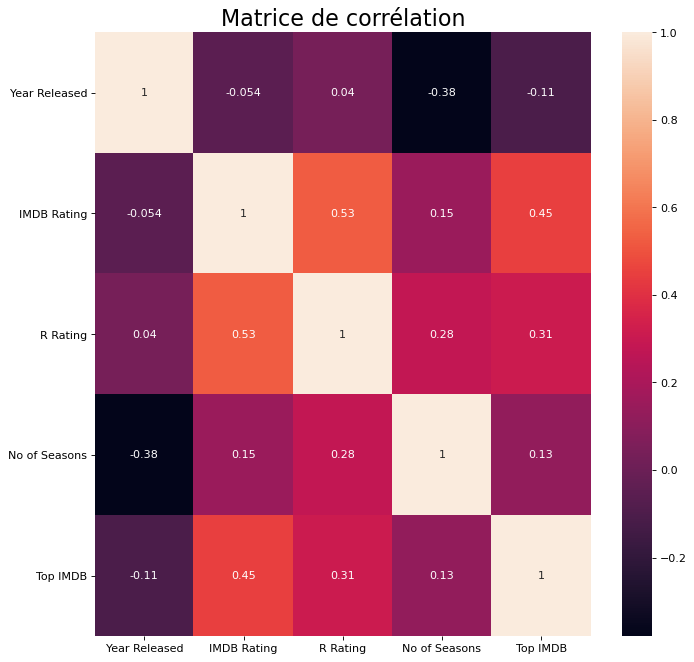

In [95]:
plotCorrelationMatrix(AS_N, 10)

Year released : aucune corrélation avec les autres variables sauf pour No of Seasons où l'on observe une corrélation négative. 

IMDB Rating : On observe une corrélation très faible avec le nombre de saisons.
    On remarque aussi une corrélation avec R Rating et Top IMDB. La corrélation avec R Rating montre qu'il y a une ressemblance dans l'appréciation des séries sans qu'elle soit identique.
    Concernant la corrélation avec Top IMDB, on aurait pu s'attendre à une valeur supérieure puisque Top IMDB est codé à partir des résultats d'IMDB Rating. 
On peut émettre l'hypothèses que cette valeur est du au caractère binaire de Top IMDB avec un seuil à 8.4.

R Rating : On remarque que  No of Seasons présente une corrélation supérieure avec Rotten Tomatoes que IMDB. Par conséquent on peut supposer que Rotten Tomatoes est plus sensible au nombre de saisons des séries.

In [96]:
"""-----------------Fonction qui trace le nuage de points entre les variables-----------------"""

def plotScatterMatrix(df, plotSize, textSize, score =0):
    
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    
    # On enlève les séries  qui présentent des valeurs manquantes pour éviter de fausser la corrélation
    df = df.dropna(subset=['Year Released', 'IMDB Rating', 'R Rating']) 
    if score ==1 : df = df.dropna(subset=['Score'])
        
    df = df.loc[(df!=0).any(axis=1)]
    df = df[[col for col in df if df[col].nunique() > 1]] 
    columnNames = list(df)
    if len(columnNames) > 10: 
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*mplt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    mplt.suptitle('Scatter and Density Plot')
    mplt.show()

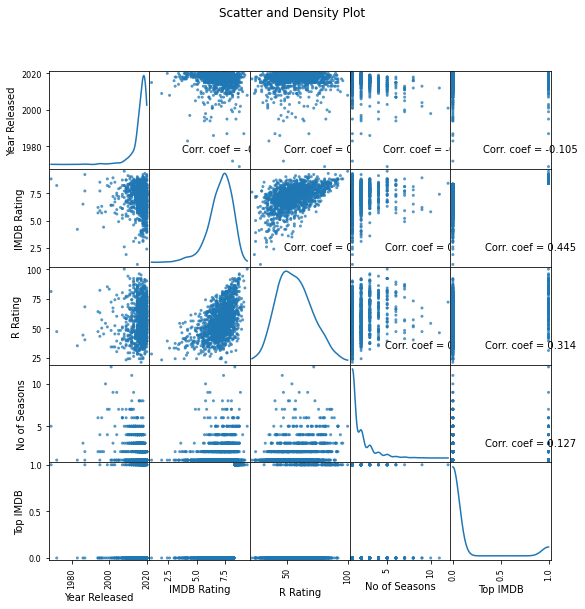

In [97]:
plotScatterMatrix (AS_N,9,10)

Le scatter plot nous permet de renforcer notre hypothèse sur la corrélation entre Top IMDB et IMDB Rating, comme Top IMDB est une variable binaire, les observations sont concentrées sur 0 entre 0 et 8.3 puis on voit un saut à 1.

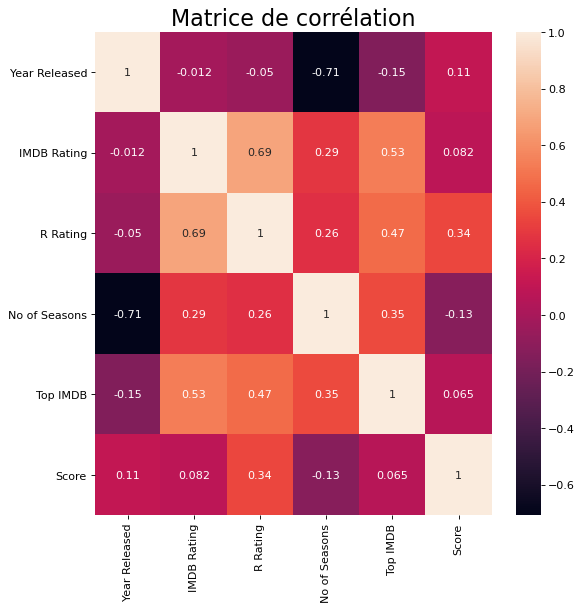

In [98]:
plotCorrelationMatrix(AS_N_x_carac, 8, 1)

On s'intéresse ici à l'échantillon de séries qui sont rentrés dans le top Netflix et qui possèdent donc un score.
L'échantillon étant une restriction de l'échantillon précédent, les valeurs ont changé.

On étudie les corrélations de la variable score: A part pour R Rating,on observe des corrélations nulles.
De fait on peut supposer une relation entre les séries beaucoup regardées sur Netflix et les notes qu'elles obtiennet sur Rotten Tomatoes (à la différence d'IMDB).

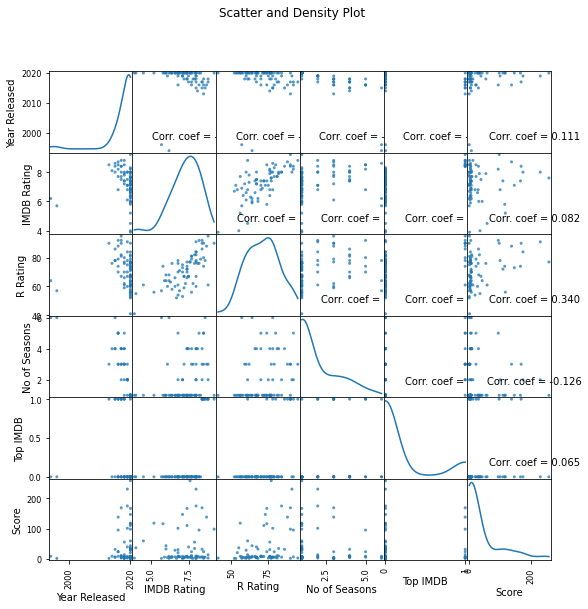

In [99]:
plotScatterMatrix (AS_N_x_carac,9,10,1)

## Représentation des profils de série

On cherche maintenant à identifier les points communs de séries regroupées selon des caractériqtiques différentes.
Ainsi on produit 5 échantillons que l'on compare entre eux.

`AS_Top` : ensemble des séries présentes dans le Top 250 d'IMDB. Il s'agit de l'échantillon de référence pour les séries excellentes.

`AS_N_Top` : ensemble des séries diffusées par Netflix présentes dans le Top 250 d'IMDB. Il s'agit d'identifier si les séries diffusées par Netflix sont appréciées par la critique.

`AS_N_score` : ensemble des séries diffusées par Netflix qui entrent dans le top journalier Netflix. On cherche à identifier si ces séries possédent les mêmes caractéristiques que celles qui entrent dans le Top IMDB.

`N_Originals` : ensemble des séries produites par Netflix. On l'utilise pour identifier les caractéristiques que Netflix souhaite mettre en avant.

`N_Originals_Top` : ensemble des séries produites par Netflix qui entrent dans le Top 250 IMDB. On cherche à savoir si les séries que produit Netflix sont de qualités.

`N_Orig_Top_N`: ensemble des séries produites par Netflix qui entrent dans le Top Netflix. On cherche à savoir si les séries que produit Netflix sont représentatives des séries populairs sur la plateforme.

In [111]:
AS_Top = AS_x_carac[AS_x_carac["Top IMDB"] == 1]
AS_N_Top = AS_N_x_carac[AS_N_x_carac["Top IMDB"] == 1]
AS_N_score = AS_N_x_carac.dropna(subset=['Score'])
N_Originals_Top = N_Originals[N_Originals["Top IMDB"] == 1]
N_Originals = AS_N_x_carac[AS_N_x_carac["Netflix Exclusive"] == 'Yes']
N_Orig_Top_N = N_Originals.dropna(subset=['Score'])

In [116]:
def BoxplotEchantillon(Var,Title, graphWidth,score=0):

    fig = go.Figure()

    fig.add_trace(go.Box(
        y = AS_Top[Var],
        name='Top IMDB',
        marker_color='#DBA506'
    ))

    fig.add_trace(go.Box(
        y = AS_N_Top[Var],
        name='Top IMDB Netflix',
        marker_color='#086A87'
    ))

    fig.add_trace(go.Box(
        y = AS_N_score[Var],
        name='Top Netflix',
        marker_color='#AB63FA'
    ))
    
    fig.add_trace(go.Box(
        y = N_Originals_Top[Var],
        name='Top IMDB Contenu Original',
        marker_color='#FF97FF'
    ))

    
    fig.add_trace(go.Box(
        y = N_Originals[Var],
        name='Contenu Original',
        marker_color='#DF0101'
    ))
    
        
    fig.add_trace(go.Box(
        y = N_Orig_Top_N[Var],
        name='Contenu Original Top Netflix',
        marker_color='orange'
    ))

    fig.update_layout(
        template = 'presentation',
        margin=dict(l=60, r=100, t=70, b=140),
        title = Title + " en fontion de l'échantillon",
        showlegend=False,
        yaxis_title='Notes',
        boxmode='group' 
    )

    fig.update_layout(legend=dict(
        yanchor="bottom",
        y=1.2,
        xanchor="right",
        x=0.01))
    
    fig.show()

In [117]:
BoxplotEchantillon('IMDB Rating','Notes IMDB',9,10)

In [118]:
BoxplotEchantillon('R Rating','Notes Rotten Tomatoes',9,10)

In [119]:
BoxplotEchantillon('Year Released','Année de sortie',9,10)

In [120]:
BoxplotEchantillon('No of Seasons','Nombre de saisons',9,10)

In [121]:
BoxplotEchantillon('Score','Score Netflix',9,10)

**Notes IMDB**: Le séries originales Netflix ont des notes très diverses, si on prend IMDB comme référence, ce sont de bonnes séries (50% entre 6.8 et 8) sans être des chefs d'oeuvre à coup sûr.
    De même Top Netflix nous montre que les séries populaires (les plus vues) sur Netflix ne sont pas forcément les meilleures.
    
**Notes Rotten Tomatoes** : à l'inverse d'IMDB, les échantillons sont assez semblables, on remarque cependant que les séries originales dans le top IMDB obtiennent de meilleures notes sur Rotten Tomatoes que les séries du Top IMDB.

Attention, on est peut être soumis à un biais ici puisqu'il y a moins de séries dans l'échantillon Top IMDB Contenu Original
    
**Année de sortie**: les séries originales sont très récente, la première date de 2014 mais avec la médiane à 2020, on observe qu'il y en a de plus en plus produites chaque année.

**Score** : on constate que les séries qui obtiennent les meilleures scores sont les séries présentent sur Netflix ce qui n'est pas surprenant. Cependant, comme Top Netflix et Contenu Original ont les mêmes valeurs, on peut supposer que les séries originales sont très représentatives des séries populaires sur la plateforme.


On continue notre démarche en nous intéressant aux genres les plus représentés selon l'échantillon.

In [126]:
"""----------Fonction qui compare les genres les plus populaires en fonction des plateformes----------"""
def comp_echantillon_genra(nombre):
    genre_count={}
    genre_count["Top IMDB"]=count_genra(AS_Top,nombre)
    genre_count["Top IMDB Netflix"]=count_genra(AS_N_Top,nombre)
    genre_count["Top Netflix"]=count_genra(AS_N_score,nombre)
    genre_count["Contenu Original"]=count_genra(N_Originals,nombre)
    genre_count["Top Imdb Contenu Original"]=count_genra(N_Originals_Top,nombre)
    genre_count["Contenu Original Top Netflix"]=count_genra(N_Orig_Top_N,nombre)

    print(genre_count)
    colors =['#DBA506','#086A87','#AB63FA','#DF0101','#FF97FF','orange']

    fig = plt.subplots.make_subplots(rows = 3, cols = 2, subplot_titles = ['Top IMDB','Top IMDB Netflix','Top Netflix','Contenu Original','Top Imdb Contenu Original','Contenu Original Top Netflix'],
                                    horizontal_spacing=0.15,
                                    vertical_spacing=0.1)
    for e,i in enumerate(['Top IMDB','Top IMDB Netflix','Top Netflix','Contenu Original','Top Imdb Contenu Original','Contenu Original Top Netflix']):
        trace = go.Bar(y = genre_count[i][1], x=genre_count[i][0],
                       marker_color=colors[e],name ="titres" , orientation = 'h')
        fig.add_trace(trace, row = (e//2) + 1, col = (e%2) + 1)

    fig.update_layout(showlegend = False)
    fig.update_layout(template = 'presentation',margin=dict(l=180, r=80, t=70, b=50),
                      title = { 'text' : '<b>Contenu le plus populaire selon les échantillons</b>', 'x' : 0.5},
                     font_family = 'Calibri', font_size = 16, title_font_color= 'black', showlegend = False)
    fig.show()
    return


In [127]:
comp_echantillon_genra(5)

{'Top IMDB': ([81, 111, 149, 224, 247], ['Crime', 'Action & Adventure', 'Comedy', 'Drama', 'Documentary']), 'Top IMDB Netflix': ([20, 21, 22, 27, 61], ['Documentary', 'Comedy', 'Action & Adventure', 'Crime', 'Drama']), 'Top Netflix': ([11, 14, 17, 20, 23], ['Reality', 'Crime', 'Drama', 'Documentary', 'Comedy']), 'Contenu Original': ([11, 12, 15, 19, 20], ['Reality', 'Crime', 'Drama', 'Documentary', 'Comedy']), 'Top Imdb Contenu Original': ([2, 2, 2, 2, 3], ['History', 'Action & Adventure', 'Crime', 'Documentary', 'Drama']), 'Contenu Original Top Netflix': ([11, 12, 15, 19, 20], ['Reality', 'Crime', 'Drama', 'Documentary', 'Comedy'])}


Attention aux échelles, beaucoup de séries ont plusieurs genres.

On remarque tout d'abord que les genres les plus représentés dans Top Netflix sont les mêmes que ceux dans Contenu Original. A l'inverse, les genres du Contenu Original ne coincident pas avec ceux du Top IMDB.
Par conséquent, on peut émettre l'hypothèse que Netflix cherche à créer des séries proches des séries populaires sur sa plateforme et que produire des séries très appréciées par la critique est un objectif secondaire.

De plus, on observe que Drama est le deuxième genre le plus représenté dans le Top 250 IMDB et nombre d'entre elles sont diffusés sur Netflix (61 sur 224) et pourtant seulement 3 ont été produite par Netflix.

Néanmoins, la box plot sur les années de sortie nous montre que la plupart des séries faisant partie du Top IMDB sont sorties il y a déja plusieures années (médiane à 2013) or Netflix a commancé à produire des séries à partir de 2014.

# Conclusion

## Principaux résultats :

### Evolution du contenu 
- De plus en plus de création originales (débute en 2014 mais explosion en 2020)
- Beaucoup de rachat : les productions originales restent minoritaires et le catalogue restent majoritairement composé de séries à succès qui ont été rachetées (très populaires : Friends, comme salué par la critique : Breaking Bad, Netflix diffuse 122 séries présentes dans le top 250 IMDB)
- Plus de films que de séries mais attention, cela ne signifie pas qu’il y a plus de contenu en termes d'heures : une série est beaucoup plus longue qu’un film.

### Succès du contenu
- Top Netflix : les séries les plus regardées sur Netflix sont très sensibles à la date de sortie, la plupart des séries entrant dans le top datent de 2020 et on constate que ce sont des genres différents des genres représentés dans le top IMDB.
- Contenu original : on remarque une surreprésentation des production originales dans le top Netlix ce qui prouve qu’elles sont très appréciées par les spectateurs de la plateforme. 
- On peut émettre l’hypothèse que Netflix cherche à produire des séries conformes aux séries les plus vues sur sa plateforme plutôt qu’aux séries saluées par la critique, représentées sur IMDB. Néanmoins on peut questionner la vraisemblance du Top Netflix puisque la plateforme met en avant ses propres productions qui sont donc plus susceptibles d’être regardées.

En somme le Top Netflix est monopolisé par le nouveau contenu original Netflix et non par les séries saluées par la critique.

### Comparaison avec les autres plateformes 
- Netflix a plus de contenu que ses concurrents et son contenu est plus récent. Cela est surement dû au poids du contenu original dans le catalogue Netflix.
- Netflix ne se démarque pas vraiment quand au genre de son contenu par rapport à ses concurrents.
- En termes de succès critique il recueille des résultats comparables aux autres plateformes sur IMDB mais s'en sort mieux sur Rotten Tomatoes.

## Observations et remarques
Ce projet aura été pour nous une première incursion dans l'analyse de données sur Python. Nous nous sommes heurtés à certains des problèmes classiques du data scientist : des index différentes empêchant les joins, des variables mal codées qui parasitent l'analyse (le problème des saisons dans `Net_tit` et les échantillons trop petits, entre autres.


